In [1]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!mkdir train_local
!unzip gdrive/MyDrive/xunfei_emotion_recognition/train.zip -d train_local/train
!unzip gdrive/MyDrive/xunfei_emotion_recognition/test.zip -d train_local/test

流式输出内容被截断，只能显示最后 5000 行内容。
 extracting: train_local/test/test/00636.png  
 extracting: train_local/test/test/01528.png  
 extracting: train_local/test/test/06247.png  
 extracting: train_local/test/test/02021.png  
 extracting: train_local/test/test/05996.png  
 extracting: train_local/test/test/04450.png  
 extracting: train_local/test/test/04336.png  
 extracting: train_local/test/test/03459.png  
 extracting: train_local/test/test/02747.png  
 extracting: train_local/test/test/05028.png  
 extracting: train_local/test/test/06521.png  
 extracting: train_local/test/test/00150.png  
 extracting: train_local/test/test/06535.png  
 extracting: train_local/test/test/00144.png  
 extracting: train_local/test/test/04322.png  
 extracting: train_local/test/test/02753.png  
 extracting: train_local/test/test/02035.png  
 extracting: train_local/test/test/05982.png  
 extracting: train_local/test/test/04444.png  
 extracting: train_local/test/test/00622.png  
 extracting: train_local/test/tes

In [3]:
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor
!pip install tensorflow_addons

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-kfluvxp3
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-kfluvxp3


In [4]:
!pip install --upgrade albumentations

In [1]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE 
import os
import cv2
from collections import Counter
import random

import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger,LearningRateScheduler,ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

import sklearn
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

import matplotlib
import matplotlib.pyplot as plt

import albumentations as A
from ImageDataAugmentor.image_data_augmentor import *
%matplotlib inline

print(tf.test.gpu_device_name())
print("Versions of key libraries")
print("---")
print("tensorflow: ", tf.__version__)
print("numpy:      ", np.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn:    ", sklearn.__version__)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


/device:GPU:0
Versions of key libraries
---
tensorflow:  2.6.0
numpy:       1.19.5
matplotlib:  3.2.2
sklearn:     0.22.2.post1


In [10]:
SEED=66
np.random.seed(SEED)
random.seed(SEED)

NUM_CLASSES= 7
LR = 0.005
BATCH_SIZE = 32
NUM_EPOCHS = 100
IMAGE_SIZE = 128  # We'll resize input images to this size

In [3]:
#load data form dir
directory='train_local/train'
dir_list=os.listdir(directory)
print('label:',dir_list)

#1. read gray and expand dimension
grayscale=False
image_data_list=[]
labels=[]
emotions=[]
l=0
for data_dir in dir_list:
    data_list=os.listdir(directory+'/'+data_dir)
    for img in data_list:
      if grayscale:
        #read as grayscale
        input_img=cv2.imread(directory+'/'+data_dir+'/'+img,cv2.IMREAD_GRAYSCALE)
        input_img=cv2.resize(input_img,(IMAGE_SIZE,IMAGE_SIZE))
        input_img=np.expand_dims(input_img, axis=2)
        image_data_list.append(input_img)
        labels.append(l)
      else:
        #read as rgb
        input_img=cv2.imread(directory+'/'+data_dir+'/'+img)
        input_img=cv2.resize(input_img,(IMAGE_SIZE,IMAGE_SIZE))
        # input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
        image_data_list.append(input_img)
        labels.append(l)
    emotions.append(data_dir)
    l=l+1

dataset_data=np.array(image_data_list)
dataset_label=np.array(labels)
print(dataset_data.shape) 

label: ['sad', 'disgusted', 'neutral', 'angry', 'surprised', 'fearful', 'happy']
(28709, 128, 128, 3)


In [4]:
#split dataset
train_x, test_x, train_y, test_y = train_test_split(dataset_data, dataset_label, test_size=0.2,random_state=SEED) 
print('data_shape:',len(dataset_label),train_x.shape,train_y.shape,test_x.shape,test_y.shape)
print('train_label:',Counter(train_y.flatten()))
print('test_label:',Counter(test_y.flatten()))
print(type(train_x),type(train_y),type(test_x),type(test_y))

data_shape: 28709 (22967, 128, 128, 3) (22967,) (5742, 128, 128, 3) (5742,)
train_label: Counter({6: 5741, 2: 4009, 0: 3870, 5: 3263, 3: 3189, 4: 2536, 1: 359})
test_label: Counter({6: 1474, 0: 960, 2: 956, 5: 834, 3: 806, 4: 635, 1: 77})
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [9]:
#data oversample but the results seems worse so abandon then I just copy the disgusted label 8 times
# train_x=train_x.reshape(train_x.shape[0],-1)
# train_y=train_y.reshape(train_y.shape[0],-1)
# print(train_x.shape,train_y.shape)
# print('train_label:',Counter(train_y.flatten()))
# print('test_label:',Counter(test_y.flatten()))
# # smote
# sm = SMOTE(random_state=0)    
# train_x, train_y = sm.fit_resample(train_x, train_y)
# print('train_label:',Counter(train_y))
# print('test_label:',Counter(test_y))
# print(train_x.shape,train_y.shape)
# train_x=train_x.reshape(train_x.shape[0],48,48,1)
# train_y=train_y.reshape(train_y.shape[0])
# print(train_x.shape,train_y.shape,test_x.shape,test_y.shape) 

In [10]:
#data augument with albumentations to try more data augment methods

In [5]:
AUGMENTATIONS_TRAIN = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomContrast(limit=0.2, p=0.5),
    A.RandomGamma(gamma_limit=(80, 120), p=0.5),
    A.RandomBrightness(limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=20,
                       val_shift_limit=10, p=.9),
    # A.CLAHE(p=1.0, clip_limit=2.0),
    A.ShiftScaleRotate(
        shift_limit=0.0625, scale_limit=0.1, 
        rotate_limit=15, border_mode=cv2.BORDER_REFLECT_101, p=0.8), 
])

AUGMENTATIONS_TEST = A.Compose([
    # A.CLAHE(p=1.0, clip_limit=2.0),
])

AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5), # horizontally flip 50% of all images
    albumentations.VerticalFlip(p=0.2), # vertically flip 20% of all images
    albumentations.ShiftScaleRotate(p=0.5)
],)  


/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1828: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1802: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


In [6]:
train_y = tf.keras.utils.to_categorical(train_y, NUM_CLASSES)
test_y = tf.keras.utils.to_categorical(test_y, NUM_CLASSES)

# dataloaders
train_gen = ImageDataAugmentor(
    featurewise_center=True,
    featurewise_std_normalization=True,
    augment=AUGMENTATIONS,
)
train_gen.fit(train_x, augment=True)

test_gen = ImageDataAugmentor(
    augment=AUGMENTATIONS_TEST, 
    featurewise_center=True,
    featurewise_std_normalization=True
)
test_gen.fit(test_x, augment=True)
# compute quantities required for featurewise normalization

train_generator = train_gen.flow(train_x, train_y, batch_size=32)
validation_generator = test_gen.flow(test_x, test_y, batch_size=32)

array([[[231, 223, 224],
        [234, 226, 227],
        [238, 230, 231],
        ...,
        [231, 223, 224],
        [229, 221, 222],
        [227, 219, 220]],

       [[233, 225, 226],
        [235, 227, 228],
        [236, 228, 229],
        ...,
        [230, 222, 223],
        [228, 220, 221],
        [226, 218, 219]],

       [[234, 226, 227],
        [235, 227, 228],
        [233, 225, 226],
        ...,
        [230, 222, 223],
        [228, 220, 221],
        [226, 218, 219]],

       ...,

       [[ 61,  59,  59],
        [ 61,  59,  59],
        [ 62,  60,  60],
        ...,
        [ 92,  89,  89],
        [ 87,  84,  84],
        [ 88,  85,  85]],

       [[ 60,  58,  58],
        [ 61,  59,  59],
        [ 62,  60,  60],
        ...,
        [ 90,  87,  87],
        [ 89,  86,  86],
        [ 89,  86,  86]],

       [[ 63,  61,  61],
        [ 64,  61,  62],
        [ 64,  62,  62],
        ...,
        [ 88,  85,  85],
        [ 90,  87,  87],
        [ 91,  88,  88]]

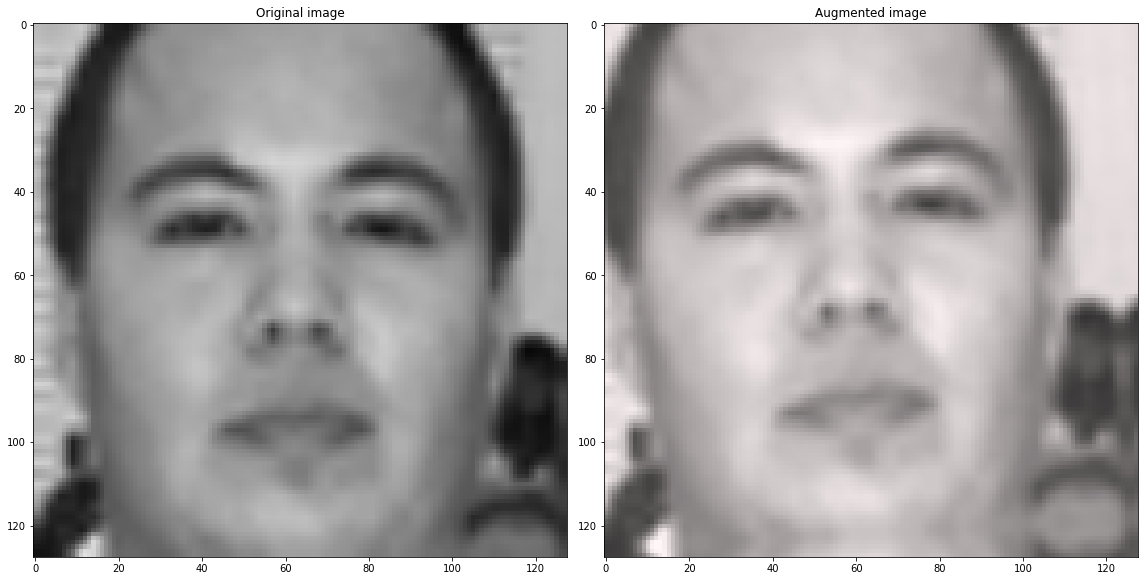

In [13]:
def augment_and_show_onlypic(aug,image,categories=[], category_id_to_name=[], filename=None, 
                     font_scale_orig=0.35, font_scale_aug=0.35, show_title=True, **kwargs):
  augmented = aug(image=image,category_id=categories)

  image = image
  image_aug = augmented['image']
  f, ax = plt.subplots(1, 2, figsize=(16, 8))
        
  ax[0].imshow(image)
  ax[0].set_title('Original image')
        
  ax[1].imshow(image_aug)
  ax[1].set_title('Augmented image')

  f.tight_layout()

  if filename is not None:
      f.savefig(filename)
        
  return augmented['image']

augment_and_show_onlypic(aug=AUGMENTATIONS_TRAIN,image=train_x[2])

# Model

In [15]:
import tensorflow_addons as tfa

def createModel():
  img_inputs = keras.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3))
  model=tf.keras.applications.ResNet101V2(include_top=False, weights='imagenet', input_tensor=img_inputs,input_shape=None, pooling='avg', classes=7)
  x=tf.keras.layers.Flatten()(model.output)
  x=tf.keras.layers.BatchNormalization()(x)
  x=tf.keras.layers.Dense(14, activation = tfa.activations.gelu)(x)
  x=tf.keras.layers.BatchNormalization()(x)
  out=tf.keras.layers.Dense(7, 'softmax')(x)

  model = keras.Model(inputs=img_inputs, outputs=out, name="ResNet101V2")
  return model

model       = createModel()   # This is meant for training
modelGo     = createModel()   # This is used for final testing
model.summary() 

Model: "ResNet101V2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 66, 66, 64)   0           conv1_conv[0][0]                 
________________________________________________________________________________________

## resnet

In [15]:
from tensorflow.keras.regularizers import l2

def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v2(input_shape, depth, num_classes=7):
    """ResNet Version 2 Model builder [b]
    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = tf.keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [16]:
resnet_model = resnet_v2(
    (IMAGE_SIZE,IMAGE_SIZE,3), 
    depth=110, num_classes=7)

# Callback

In [16]:
from tensorflow.keras.callbacks import Callback
import tensorflow.keras.backend as K

modelname='ResNet101V2'

callbacks_list  = []

class WarmupExponentialDecay(Callback):
    def __init__(self,lr_base=0.0002,lr_min=0.0,decay=0,warmup_epochs=0):
        self.num_passed_batchs = 0   #count
        self.warmup_epochs=warmup_epochs  
        self.lr=lr_base #learning_rate_base
        self.lr_min=lr_min 
        self.decay=decay  #decay
        self.steps_per_epoch=0 #count
    def on_batch_begin(self, batch, logs=None):
        if self.steps_per_epoch==0:
            if self.params['steps'] == None:
                self.steps_per_epoch = np.ceil(1. * self.params['samples'] / self.params['batch_size'])
            else:
                self.steps_per_epoch = self.params['steps']
        if self.num_passed_batchs < self.steps_per_epoch * self.warmup_epochs:
            K.set_value(self.model.optimizer.lr,
                        self.lr*(self.num_passed_batchs + 1) / self.steps_per_epoch / self.warmup_epochs)
        else:
            K.set_value(self.model.optimizer.lr,
                        self.lr*((1-self.decay)**(self.num_passed_batchs-self.steps_per_epoch*self.warmup_epochs)))
        self.num_passed_batchs += 1
    def on_epoch_begin(self,epoch,logs=None):
    #print lr
        print("learning_rate:",K.get_value(self.model.optimizer.lr))

# WarmupExponentialDecay(lr_base=0.0002,decay=0.00002,warmup_epochs=2)
# callbacks_list.append(es)


es = EarlyStopping(
    monitor='val_accuracy', min_delta=0.0001, patience=10, verbose=2,
    mode='max', baseline=None, restore_best_weights=True
)
callbacks_list.append(es)
lr = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=5, verbose=2,
    mode='max', min_delta=1e-5, cooldown=0, min_lr=0
)
callbacks_list.append(lr)

def lrSchedule(epoch):
    mode='progressive_drops'
    lr_base = LR
    lr_decay = 0.1
    lr = lr_base
    epochs=NUM_EPOEHES
    if mode == 'power_decay':
        # original lr schedulera
        lr = lr_base * ((1 - float(epoch) / epochs) ** lr_power)
    if mode == 'exp_decay':
        # exponential decay
        lr = (float(lr_base) ** float(lr_power)) ** float(epoch + 1)
    # adam default lr
    if mode == 'adam':
        lr = 0.001

    if mode == 'progressive_drops':
       if epoch > 0.9 * epochs:
          lr = lr*lr_decay*lr_decay*lr_decay
       elif epoch > 0.75 * epochs:
          lr = lr*lr_decay*lr_decay
       elif epoch > 0.5 * epochs:
          lr = lr*lr_decay
       else:
          lr = lr_base

    print('lr: %f' % lr)
    return lr

LRScheduler     = LearningRateScheduler(lrSchedule)
# callbacks_list.append(LRScheduler)
                                                                                
folderpath      = '/content/gdrive/MyDrive/xunfei_emotion_recognition/'
filepath        = folderpath + modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_accuracy', 
                                  verbose=1, 
                                  save_best_only=True, 
                                  mode='max')
callbacks_list.append(checkpoint)
csv_logger      = CSVLogger(folderpath+modelname +'.csv',append=False)                       
callbacks_list.append(csv_logger)                     

print("Callbacks created:")
print(callbacks_list[0])
print(callbacks_list[1])
print(callbacks_list[2])
print('')
print("Path to model:", filepath)
print("Path to log:  ", folderpath+modelname+'.csv')

Callbacks created:

Path to model: /content/gdrive/MyDrive/xunfei_emotion_recognition/ResNet101V2.hdf5
Path to log:   /content/gdrive/MyDrive/xunfei_emotion_recognition/ResNet101V2.csv


In [18]:
optimizer = tf.optimizers.Adam(tf.keras.optimizers.schedules.CosineDecay(LR,100)) 
model.compile(optimizer = 'adam', 
              loss = tfa.losses.SigmoidFocalCrossEntropy(reduction=tf.keras.losses.Reduction.AUTO), 
              # loss='categorical_crossentropy',
              metrics = ['accuracy'])

model_history=model.fit(x = train_generator,
          validation_data = validation_generator,
          epochs = 200,
           verbose=1,
          callbacks=callbacks_list) 

Epoch 1/100
718/718 [==============================] - 110s 139ms/step - loss: 0.3514 - accuracy: 0.2406 - val_loss: 3.6744 - val_accuracy: 0.2161

Epoch 00001: val_accuracy improved from -inf to 0.21613, saving model to /content/gdrive/MyDrive/xunfei_emotion_recognition/ResNet101V2.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
718/718 [==============================] - 99s 137ms/step - loss: 0.3391 - accuracy: 0.2452 - val_loss: 0.3725 - val_accuracy: 0.2557

Epoch 00002: val_accuracy improved from 0.21613 to 0.25566, saving model to /content/gdrive/MyDrive/xunfei_emotion_recognition/ResNet101V2.hdf5
Epoch 3/100
718/718 [==============================] - 99s 137ms/step - loss: 0.3377 - accuracy: 0.2467 - val_loss: 0.4143 - val_accuracy: 0.2490

Epoch 00003: val_accuracy did not improve from 0.25566
Epoch 4/100
718/718 [==============================] - 98s 137ms/step - loss: 0.3372 - accuracy: 0.2490 - val_loss: 0.9923 - val_accuracy: 0.2316

Epoch 00004: val_accuracy did not improve from 0.25566
Epoch 5/100
718/718 [==============================] - 98s 137ms/step - loss: 0.3374 - accuracy: 0.2486 - val_loss: 0.3376 - val_accuracy: 0.2544

Epoch 00005: val_accuracy did not improve from 0.25566
Epoch 6/100
718/718 [==============================] - 99s 137ms/step - loss: 0.3356 - accuracy: 0.2482

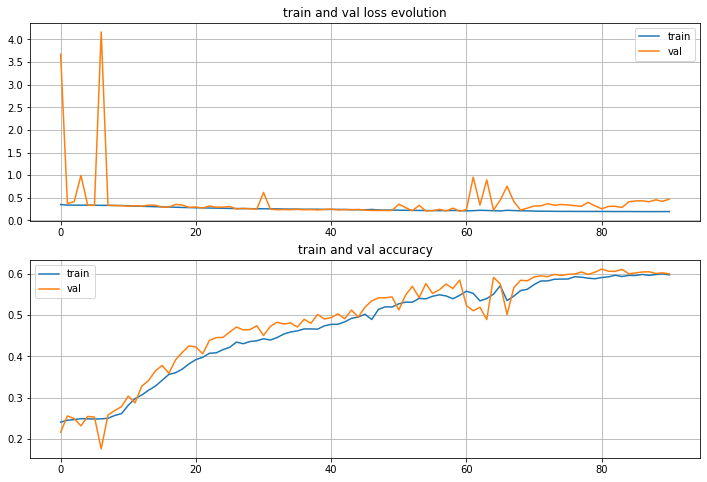

In [19]:
def plot_performance(history):
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')

    plt.legend()
    plt.grid()
    plt.title('train and val loss evolution')

    plt.subplot(2, 1, 2)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')

    plt.legend()
    plt.grid()
    plt.title('train and val accuracy')
plot_performance(model_history)